In [1]:
## Data Preprocessing

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time
from collections import defaultdict

# Read data_train
train_set = np.genfromtxt('data_oct.csv', skip_header=1, delimiter=',')

# Get speed data (kph) for regular, AM peak, PM peak
speed_regular = train_set[:,0]
speed_AMpeak = train_set[:,3]
speed_PMpeak = train_set[:,5]

speed_regular = speed_regular[~np.isnan(speed_regular)]
speed_AMpeak = speed_AMpeak[~np.isnan(speed_AMpeak)]
speed_PMpeak = speed_PMpeak[~np.isnan(speed_PMpeak)]

# Get distance data (km) for regular, AM peak, PM peak
# x: input parameter
dist_regular = train_set[:,2]
dist_AMpeak = train_set[:,4]
dist_PMpeak = train_set[:,6]

dist_regular = dist_regular[~np.isnan(dist_regular)]
dist_AMpeak = dist_AMpeak[~np.isnan(dist_AMpeak)]
dist_PMpeak = dist_PMpeak[~np.isnan(dist_PMpeak)]

# Calculate travel time data (minutes) for regular, AM peak, PM peak
# y: ground truth
time_regular = dist_regular / speed_regular 
time_AMpeak = dist_AMpeak / speed_AMpeak
time_PMpeak = dist_PMpeak / speed_PMpeak

def gkernel(x, b, x_data, y_data):
    xx = x - x_data
    K = (1/((np.sqrt(2*np.pi))))*np.exp(-0.5 *(xx/b)**2)
    while np.all(K==0):
        b = b*10
        K = (1/((np.sqrt(2*np.pi))))*np.exp(-0.5 *(xx/b)**2)
    Ksum = np.sum(K)
    weight = K/Ksum
    yk = sum(weight*y_data)
    xkyk = np.array([[x], [yk]])
    return ykernel, xkyk

In [2]:
## Preprocess Commuter Input
stations = np.loadtxt('data_stations.csv', skiprows=1, delimiter=',')
data_dist = stations[:,1]

in_start = 0 #Monumento
in_stop = 4 #Roosevelt

if in_start <= in_stop: #southbound
    xesti = np.sum(data_dist[in_start:in_stop]) 
else: #northbound
    xesti = np.sum(data_dist[in_stop:in_start])

print("Distance: ", xesti)


Distance:  4250.0


In [3]:
## Get Time

def in_between(now, start, end):
    if start <= end:
        return start <= now < end
    else: # over midnight e.g., 23:30-04:15
        return start <= now or now < end
    
now = datetime.now().time()

if in_between(now, time(6), time(9)):
    period = 'AM peak' #Between 6 to 9AM
    b = 500
    x = dist_AMpeak
    y = time_AMpeak
elif in_between(now, time(17), time(21)): 
    period = 'PM peak' #Between 5 to 9PM
    b = 500
    x = dist_PMpeak
    y = time_PMpeak
else:
    period = 'Regular' #Outside AM and PM peak
    b = 100
    x = dist_regular
    y = time_regular

print("Period: ", period)
print("Current Time: ", now)

Period:  Regular
Current Time:  11:19:25.944967


In [4]:
## Prediction Printing

ykernel = np.array([[],[]])

ykernel, xkyk = gkernel(xesti, b, x, y)
print("Next bus will arrive at ", xkyk[1][0], "minutes.")

Next bus will arrive at  10.760551046213434 minutes.


<function matplotlib.pyplot.show(close=None, block=None)>

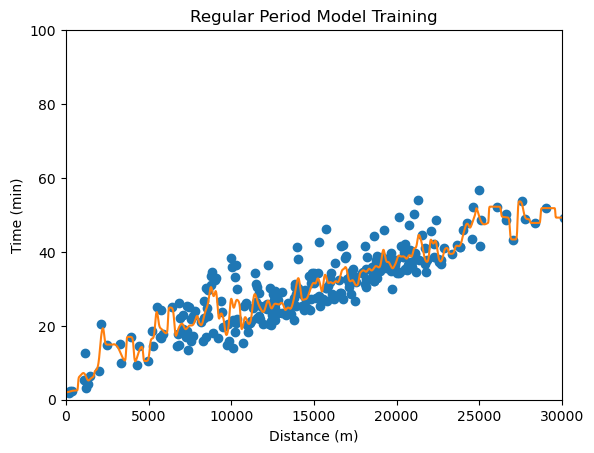

In [5]:
## Regular Period

b = 100 #bandwidth
kdeEstimateyX = np.arange(0, 30000, 10)
ykernel = np.array([[],[]])

for xesti in kdeEstimateyX:
    ykernel, xkyk = gkernel(xesti, b, dist_regular, time_regular)
    ykernel = np.append(ykernel,xkyk, axis=1)

## Plotting

plt.plot(dist_regular, time_regular, 'o')
plt.plot(ykernel[0], ykernel[1])

plt.title("Regular Period Model Training")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Time (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(0,100)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

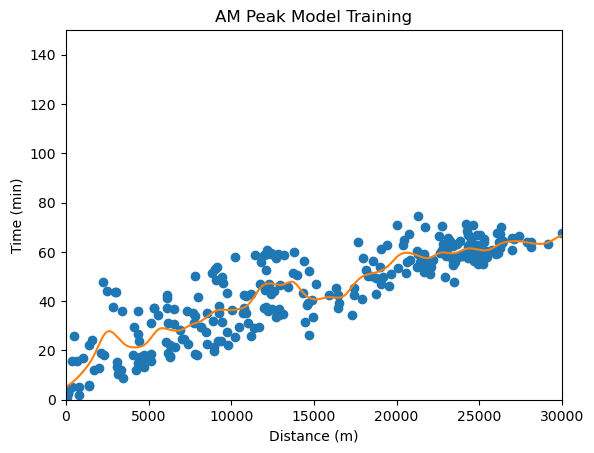

In [6]:
## AM Peak Period

b = 500 #bandwidth
kdeEstimateyX = np.arange(0, 30000, 10)
ykernel = np.array([[],[]])

for xesti in kdeEstimateyX:
    ykernel, xkyk = gkernel(xesti, b, dist_AMpeak, time_AMpeak)
    ykernel = np.append(ykernel,xkyk, axis=1)

## Plotting

plt.plot(dist_AMpeak, time_AMpeak, 'o')
plt.plot(ykernel[0], ykernel[1])

plt.title("AM Peak Model Training")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Time (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(0,150)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

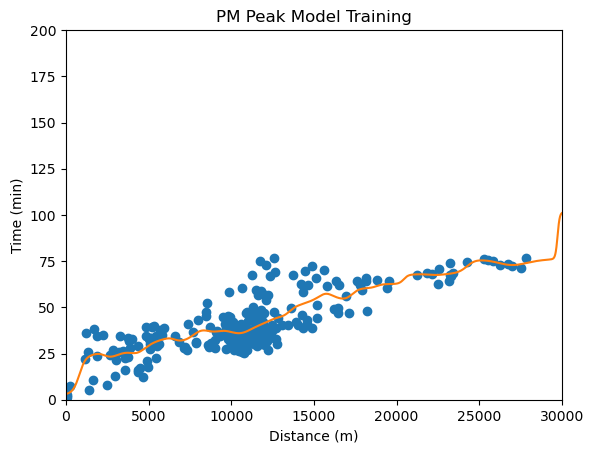

In [7]:
## PM Peak Period

b = 500 #bandwidth
kdeEstimateyX = np.arange(0, 30000, 10)
ykernel = np.array([[],[]])

for xesti in kdeEstimateyX:
    ykernel, xkyk = gkernel(xesti, b, dist_PMpeak, time_PMpeak)
    ykernel = np.append(ykernel,xkyk, axis=1)

## Plotting

plt.plot(dist_PMpeak, time_PMpeak, 'o')
plt.plot(ykernel[0], ykernel[1])

plt.title("PM Peak Model Training")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Time (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(0,200)

plt.show

In [8]:
## Data Testing

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Read data_train
test_set = np.genfromtxt('data_test_oct.csv', delimiter=',', skip_header=1)
# Get speed data (kph) for regular, AM peak, PM peak
speed_regular_true = test_set[:,0]
speed_AMpeak_true = test_set[:,3]
speed_PMpeak_true = test_set[:,5]

speed_regular_true = speed_regular_true[~np.isnan(speed_regular_true)]
speed_AMpeak_true = speed_AMpeak_true[~np.isnan(speed_AMpeak_true)]
speed_PMpeak_true = speed_PMpeak_true[~np.isnan(speed_PMpeak_true)]

# Get distance data (km) for regular, AM peak, PM peak
# x: input parameter
dist_regular_true = test_set[:,2]
dist_AMpeak_true = test_set[:,4]
dist_PMpeak_true = test_set[:,6]

dist_regular_true = dist_regular_true[~np.isnan(dist_regular_true)]
dist_AMpeak_true = dist_AMpeak_true[~np.isnan(dist_AMpeak_true)]
dist_PMpeak_true = dist_PMpeak_true[~np.isnan(dist_PMpeak_true)]

# Calculate travel time data (minutes) for regular, AM peak, PM peak
# y: ground truth
time_regular_true = dist_regular_true / speed_regular_true 
time_AMpeak_true = dist_AMpeak_true / speed_AMpeak_true
time_PMpeak_true = dist_PMpeak_true / speed_PMpeak_true

MAPE for regular:  9.282805140004196 %
RMSE for regular:  3.4259203191484096 minutes
MAE for Regular:  11.281065810701493 minutes


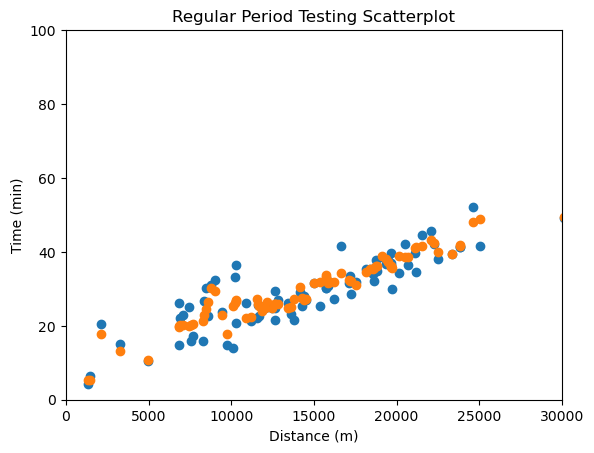

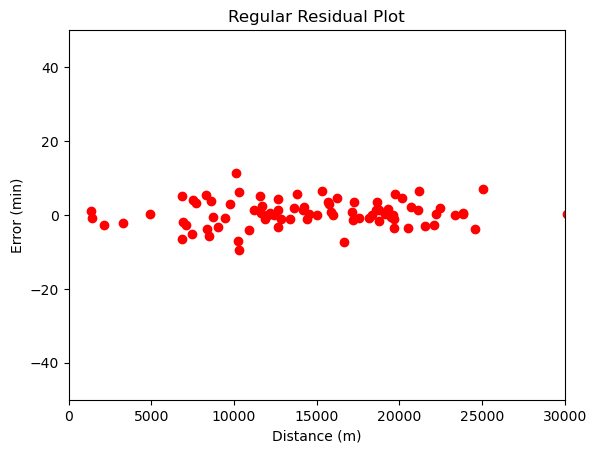

In [9]:
## Regular Period Testing

b = 100
ykernel = np.array([[],[]])

for xesti in dist_regular_true:
    ykernel, xkyk = gkernel(xesti, b, dist_regular, time_regular)
    ykernel = np.append(ykernel,xkyk, axis=1)
    
print("MAPE for regular: ", mean_absolute_percentage_error(time_regular_true, ykernel[1])*100, "%")
print("RMSE for regular: ", mean_squared_error(time_regular_true, ykernel[1], squared=False), "minutes")
print("MAE for Regular: ", np.amax(np.abs(ykernel[1] - time_regular_true)), "minutes")

# Scatterplot
f1 = plt.figure()
plt.plot(dist_regular_true, time_regular_true, 'o')
plt.plot(ykernel[0], ykernel[1], 'o')

plt.title("Regular Period Testing Scatterplot")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Time (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(0,100)

f4 = plt.figure()
plt.plot(dist_regular_true, ykernel[1] - time_regular_true, 'o', color = 'r')

plt.title("Regular Residual Plot")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Error (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(-50,50)

plt.show()


MAPE for AM peak:  22.782830095773576 %
RMSE for AM peak:  7.013264987280747 minutes
MAE for AM peak:  17.74581045600038 minutes


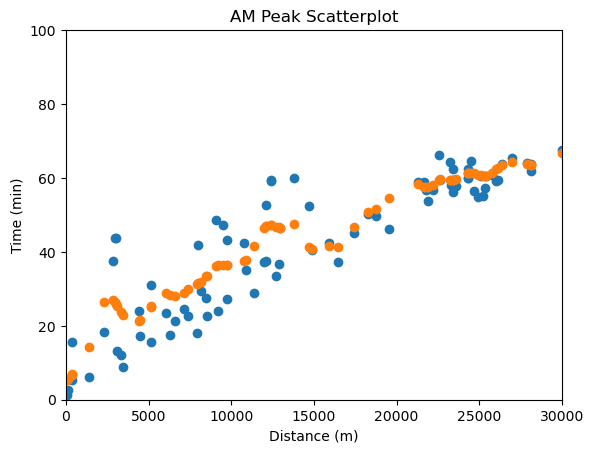

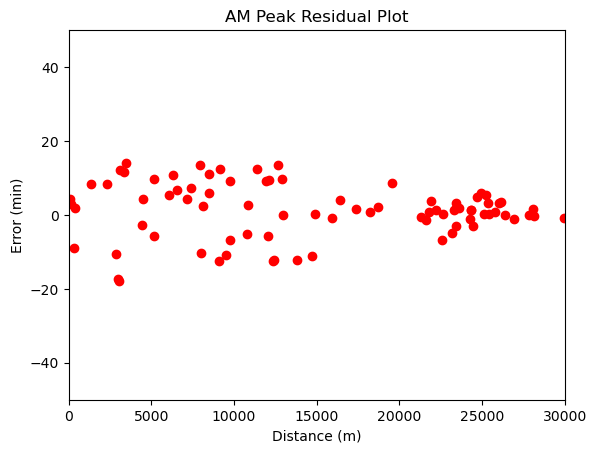

In [10]:
## AM Period Testing

b = 500
ykernel = np.array([[],[]])

for xesti in dist_AMpeak_true:
    ykernel, xkyk = gkernel(xesti, b, dist_AMpeak, time_AMpeak)
    ykernel = np.append(ykernel,xkyk, axis=1)
    
print("\nMAPE for AM peak: ", mean_absolute_percentage_error(time_AMpeak_true, ykernel[1])*100, "%")
print("RMSE for AM peak: ", mean_squared_error(time_AMpeak_true, ykernel[1], squared=False), "minutes")
print("MAE for AM peak: ", np.amax(np.abs(ykernel[1] - time_AMpeak_true)), "minutes")

f2 = plt.figure()
plt.plot(dist_AMpeak_true, time_AMpeak_true, 'o')
plt.plot(ykernel[0], ykernel[1], 'o')

plt.title("AM Peak Scatterplot")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Time (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(0,100)

f5 = plt.figure()
plt.plot(dist_AMpeak_true, ykernel[1] - time_AMpeak_true, 'o', color = 'r')

plt.title("AM Peak Residual Plot")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Error (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(-50,50)

plt.show()


MAPE for PM peak:  16.476670562073732 %
RMSE for PM peak:  7.918470993660352 minutes
MAE for PM peak:  34.51537713489366 minutes


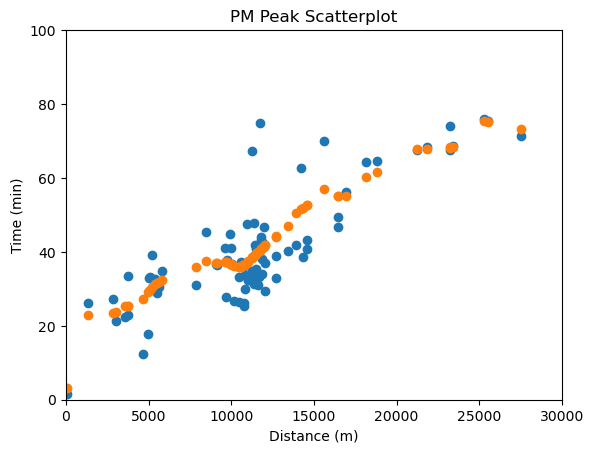

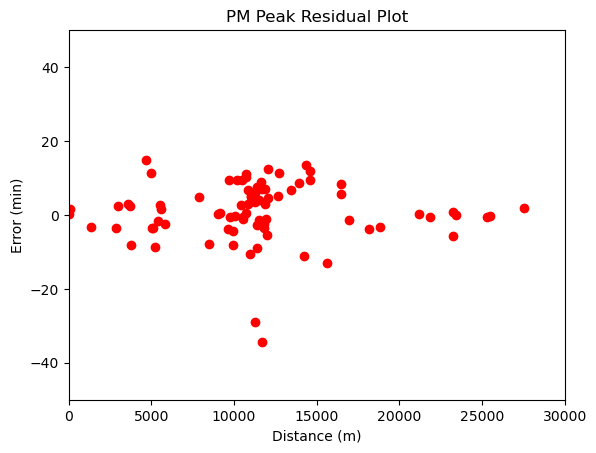

In [11]:
## PM Period Testing

b = 500
ykernel = np.array([[],[]])

for xesti in dist_PMpeak_true:
    ykernel, xkyk = gkernel(xesti, b, dist_PMpeak, time_PMpeak)
    ykernel = np.append(ykernel,xkyk, axis=1)
    
print("\nMAPE for PM peak: ", mean_absolute_percentage_error(time_PMpeak_true, ykernel[1])*100, "%")
print("RMSE for PM peak: ", mean_squared_error(time_PMpeak_true, ykernel[1], squared=False), "minutes")
print("MAE for PM peak: ", np.amax(np.abs(ykernel[1] - time_PMpeak_true)), "minutes")

f3 = plt.figure()
plt.plot(dist_PMpeak_true, time_PMpeak_true, 'o')
plt.plot(ykernel[0], ykernel[1], 'o')

plt.title("PM Peak Scatterplot")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Time (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(0,100)

f6 = plt.figure()
plt.plot(dist_PMpeak_true, ykernel[1] - time_PMpeak_true, 'o', color = 'r')

plt.title("PM Peak Residual Plot")
plt.xlabel("Distance (m)") # in meters
plt.ylabel("Error (min)") # in minutes

plt.xlim(0,30000)
plt.ylim(-50,50)

plt.show()